# L3: Text clustering and topic modelling

Text clustering groups documents in such a way that documents within a group are more &lsquo;similar&rsquo; to other documents in the cluster than to documents not in the cluster. The exact definition of what &lsquo;similar&rsquo; means in this context varies across applications and clustering algorithms.

In this lab you will experiment with both hard and soft clustering techniques. More specifically, in the first part you will be using the $k$-means algorithm, and in the second part you will be using a topic model based on the Latent Dirichlet Allocation (LDA).

## Hard clustering data set

The raw data for the hard clustering part of this lab is a collection of product reviews. We have preprocessed the data by tokenization and lowercasing.

In [15]:
import pandas as pd
import bz2

with bz2.open("reviews.json.bz2") as source:
    df = pd.read_json(source)

When you inspect the data frame, you can see that there are three labelled columns: `category` (the product category), `sentiment` (whether the product review was classified as &lsquo;positive&rsquo; or &lsquo;negative&rsquo; towards the product), and `text` (the space-separated text of the review).

In [16]:
df.head(n=10)

,category,sentiment,text
0,music,neg,i bought this album because i loved the title ...
1,music,neg,i was misled and thought i was buying the enti...
2,books,neg,"i have introduced many of my ell , high school..."
3,books,pos,anything you purchase in the left behind serie...
4,dvd,pos,"i loved these movies , and i cant wiat for the..."
5,camera,neg,"in my experience , this camera takes great pic..."
6,books,neg,first off i 'd like to tell you that this is o...
7,health,pos,this is a very good shaver for the private are...
8,books,neg,not even worth finishing this book ! this auth...
9,books,pos,if you 're intimidated by tolstoy or dostoevsk...


In [17]:
df.shape

(11914, 3)

In [18]:
print('The distinct categories are: ',df.category.unique())

The distinct categories are:  ['music' 'books' 'dvd' 'camera' 'health' 'software']


## Problem 1: K-means clustering

Your first task is to cluster the product review data using a tf–idf vectorizer and a $k$-means clusterer.

Start by doing the vectorization. In connection with vectorization, you should also filter out standard English stop words. While you could use [spaCy](https://spacy.io/) for this task, here it suffices to use the word list implemented in [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [19]:
# TODO: Enter code here to vectorize the data
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer 

# class LemmaTokenizer(object):
#     def __init__(self):
#         self.wnl = WordNetLemmatizer()
#     def __call__(self, articles):
#         return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

vectorizer = TfidfVectorizer(stop_words='english')
                              #,tokenizer=LemmaTokenizer())

reviews = vectorizer.fit_transform(df['text'])


Test your vectorization by running the following code cell:

In [20]:
reviews.shape

(11914, 46619)

If you used the English stop word list from scikit-learn, then the resulting vocabulary should have 46,619 entries.

Next, cluster the vectorized data. Before doing so, you should read the documentation of the [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class, which is scikit-learn&rsquo;s implementation of the $k$-means algorithm. As you can see, this class has several parameters that you can tweak. For now, the only parameter that you will have to set is the number of clusters. We recommend that you choose $k=3$.

**Tip:** Training $k$-means models will take some time. To speed things up, you can use the `n_init` parameter to control the number of times that the clustering is re-computed with different initial values. The default value for this parameter is 10; here and in the rest of this lab, you may want to set this to a lower value.

In [21]:
# TODO: Enter code here to cluster the vectorized data
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init=2,random_state=13).fit(reviews)

To sanity-check your clustering, create a bar plot with the number of documents per cluster.

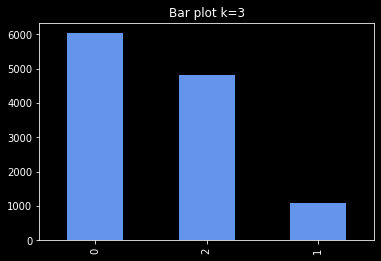

In [23]:
# TODO: Enter code here to produce a bar plot of the cluster size
import matplotlib.pyplot as plt

plt.style.use('dark_background')
pd.Series(kmeans.labels_).value_counts().plot(kind='bar',color='cornflowerblue')
plt.title('Bar plot k=3')
plt.show()

Note that sizes may vary considerable between clusters and among different random seeds.

## Problem 2: Summarize clusters

Once you have a clustering, you can try to see whether it is meaningful. One useful technique in that context is to generate a **summary** for each cluster by extracting the $n$ highest-weighted terms from the centroid of each cluster. Your next task is to implement this approach.

**Hint:** You will need to construct an &lsquo;inverted vocabulary&rsquo; that allows you to map from the index of a term back to the original term.

In [36]:
# TODO: Enter code here to compute the cluster summaries and print them
import numpy as np
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
labels_true = le.fit_transform(df['category'])

n=4

print(kmeans.cluster_centers_.shape)
cluster_centers = kmeans.cluster_centers_

c= []

for cluster in kmeans.cluster_centers_:
    ind = np.argpartition(cluster, -n)[-n:]
    c.append(ind)
    #c.append(cluster[cluster.argsort()[-n:]])
c

(3, 46619)


[array([ 2193, 24390, 27522,  5695]),
 array([ 6980, 31125, 24143,  6890]),
 array([12823, 38539, 44007, 32505])]

In [37]:
res = kmeans.__dict__

print(res['cluster_centers_'])

[[3.05042594e-04 5.28391140e-04 0.00000000e+00 ... 4.45502443e-05
  3.44213882e-05 2.35197077e-05]
 [2.07289830e-03 9.97789218e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.42649530e-03 8.37028586e-04 5.37167764e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


Once you have computed the cluster summaries, discuss their quality. Is it clear what the reviews in a given cluster are about? Which clusters are clearest? Which are less clear? Do the cluster summaries contain any unexpected terms? What happens if you re-cluster with, say, $k=6$?

*TODO: Insert your analysis of the clusters here*

## Problem 3: Tune the k-means algorithm

A major limitation of the $k$-means algorithm is that one has to manually set the value for $k$, the number of clusters. One heuristic that can help you with this is the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). Your next task is to implement this method to see whether it allows you to find a better value for $k$.

To follow the elbow method, you should plot different values of $k$ against the **inertia** (sums of squared distances between documents and closest centroids) of the fitted $k$-means model, and pick the $k$ at the &lsquo;elbow point&rsquo; of the resulting graph. Test cluster sizes between 1 and 9.

**Note that this will take a while.**

In [38]:
# TODO: Enter code here to generate the plot for the elbow method
from sklearn import metrics
import time


distorsions = []

start_time= time.time()
n_clusters = range(1,10)

for i,k in enumerate(n_clusters):
    print('iteration:{0},n_clusters:{1}'.format((i+1),k))
    kmeans = KMeans(n_clusters=k,n_init=2,random_state=13)
    kmeans.fit(reviews)
    inertia = kmeans.inertia_
    distorsions.append(inertia)
    
end_time = time.time()-start_time
measured_time = time.strftime("%H:%M:%S", time.gmtime(end_time))
print('Time to execute for loop :' ,measured_time)

distorsions

iteration:1,n_clusters:1
iteration:2,n_clusters:2
iteration:3,n_clusters:3
iteration:4,n_clusters:4
iteration:5,n_clusters:5
iteration:6,n_clusters:6
iteration:7,n_clusters:7
iteration:8,n_clusters:8
iteration:9,n_clusters:9
Time to execute for loop : 00:03:42


[11764.202585909867,
 11712.715826404263,
 11655.90941716431,
 11616.53569806913,
 11584.608555614535,
 11552.701543867817,
 11532.56222839533,
 11496.555571793015,
 11479.845659218136]

Text(0.5, 1.0, 'Elbow curve plot')

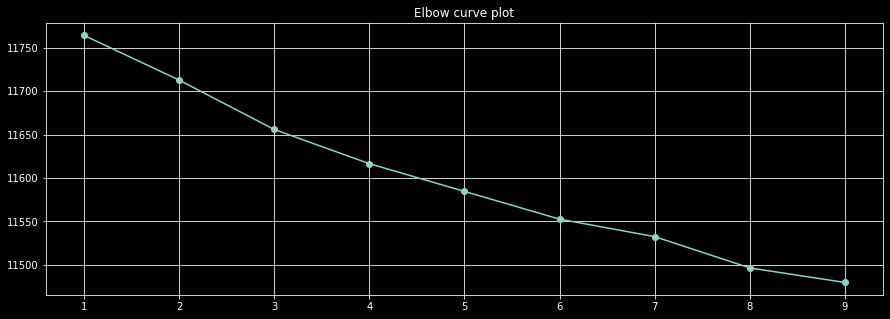

In [40]:
# plot the elbow    
fig = plt.figure(figsize=(15, 5))
plt.plot(n_clusters,distorsions,marker='o')
plt.grid(True)
plt.title('Elbow curve plot')

Once you have the diagram, can you see a pronounced &lsquo;elbow point&rsquo;? Discuss your findings in a short text.

*TODO: Insert your discussion of the elbow method here*

## Problem 4: Compare clusterings using the Rand index

In some scenarios, you may have gold-standard class labels available for at least a subset of your documents. In these cases you can compute the **Rand index** of a clustering, and use this measure to compare the quality of different clusterings.

To compute the Rand index, we view a clustering as a binary classifier on pairs of documents. The classifier predicts &lsquo;positive&rsquo; if and only if the two documents belong to the same cluster. The (non-normalized) Rand index of the clustering is the accuracy of this classifier relative to a reference in which a document pair belongs to the &lsquo;positive&rsquo; class if and only if the two documents in the pair have the same gold-standard class label.

Compare a clustering with $k=3$ clusters to a second clustering with $k=6$ clusters. As your evaluation data, use the first 500 documents from the original data set along with their gold-standard categories (from the `category` column). What do you observe? How do you interpret your observations? What arguments can you find against the Rand index as a measure for comparing clusterings?

In [41]:
# TODO: Enter code here to compute the Rand indices for the two clusterings
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
labels_true = le.fit_transform(df['category'])


In [42]:
clusters = [3,6]
rnd_index = []

for i in clusters :
    kmeans_ = KMeans(n_clusters=i,n_init=2,random_state=13).fit(reviews)
    labels_pred = le.inverse_transform(kmeans_.predict(reviews))
    rnd_ind = adjusted_rand_score(df['category'], labels_pred)
    rnd_index.append(rnd_ind)


In [43]:
rnd_index

[0.30541288952688855, 0.32286340837152966]

*TODO: Insert your discussion of your results here*

## Topic modelling data set

The data set for the topic modelling part of this lab is the collection of all [State of the Union](https://en.wikipedia.org/wiki/State_of_the_Union) addresses from the years 1975–2000. These speeches come as a single text file with one sentence per line. The following code cell prints the first 5 lines from the data file:

In [1]:
with open("sotu_1975_2000.txt") as source:
    for i, line in enumerate(source):
        print(line.rstrip())
        if i >= 5:
            break

mr speaker mr vice president members of the 94th congress and distinguished guests
twenty six years ago a freshman congressman a young fellow with lots of idealism who was out to change the world stood before sam rayburn in the well of the house and solemnly swore to the same oath that all of you took yesterday an unforgettable experience and i congratulate you all
two days later that same freshman stood at the back of this great chamber over there someplace as president truman all charged up by his single handed election victory reported as the constitution requires on the state of the union
when the bipartisan applause stopped president truman said i am happy to report to this 81st congress that the state of the union is good our nation is better able than ever before to meet the needs of the american people and to give them their fair chance in the pursuit of happiness it is foremost among the nations of the world in the search for peace
today that freshman member from michigan stan

## Problem 5: Train a topic model

Your first task on the topic modelling data is to train an LDA model. For this task you will be using [spaCy](https://spacy.io/) and the [gensim](https://radimrehurek.com/gensim/) topic modelling library.

Start by preprocessing the data using spaCy. Given that the data set for this problem is rather small, you do not have to exclude any components from the standard pipeline. Filter out stop words, non-alphabetic tokens, and tokens less than 3 characters in length. Store the documents as a nested list where the first level of nesting corresponds to the sentences and the second level corresponds to the tokens in each sentence.

In [2]:
# TODO: Replace the following lines with your own code for preprocessing the documents
with open("sotu_1975_2000.txt") as source:
    documents = [line.split() for line in source]

In [3]:
documents[42]

['first',
 'we',
 'must',
 'reduce',
 'oil',
 'imports',
 'by',
 '1',
 'million',
 'barrels',
 'per',
 'day',
 'by',
 'the',
 'end',
 'of',
 'this',
 'year',
 'and',
 'by',
 '2',
 'million',
 'barrels',
 'per',
 'day',
 'by',
 'the',
 'end',
 'of',
 '1977']

In [4]:
import spacy #load spacy
from spacy.lang.en.stop_words import STOP_WORDS


nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])

def preprocess(text):
    # TODO: Replace the next line with your own code.
    filtered_sentence =[] 
    
    for sentence in text :
        words = []
        for word in sentence:
            lexeme = nlp.vocab[word]
            if not lexeme.is_stop and not lexeme.is_punct and lexeme.is_alpha and len(word)>=3:
                words.append(word)
        filtered_sentence.append(words)
  
    return filtered_sentence

sentence = preprocess(documents)

Test your preprocessing by running the following cell:

In [5]:
" ".join(preprocess(documents)[42])

'reduce oil imports million barrels day end year million barrels day end'

You should get the following output:

Once you have the list of documents, skim the section [Pre-process and vectorize the documents](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents) of the gensim documentation to learn how to create the dictionary and the vectorized corpus representation required by gensim. (Note that you cannot use the standard scikit-learn pipeline in this case.) Then, write code to train an [LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html) for $k=10$ topics, and using default values for all other parameters.

In [6]:
# TODO: Enter code here to train an LDA model

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel



# Create Dictionary
id2word = Dictionary(sentence)

# Create Corpus
texts = sentence

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

# # Create a corpus from a list of texts
# common_dictionary = Dictionary(sentence)
# common_corpus = [common_dictionary.doc2bow(text) for text in sentence]

# # Train the model on the corpus.


[[('congress', 1),
  ('distinguished', 1),
  ('guests', 1),
  ('members', 1),
  ('president', 1),
  ('speaker', 1),
  ('vice', 1)]]

In [7]:

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# temp = common_dictionary[0]  # This is only to "load" the dictionary.
# id2word = common_dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

Once you have a trained model, run the following cell to print the topics:

In [8]:
top_topics = model.top_topics(corpus)

from pprint import pprint
pprint(top_topics)

[([(0.015295606, 'government'),
   (0.013922689, 'people'),
   (0.012130778, 'new'),
   (0.011363502, 'years'),
   (0.011116078, 'american'),
   (0.010059574, 'america'),
   (0.008970668, 'year'),
   (0.0088462895, 'budget'),
   (0.008233149, 'let'),
   (0.006751675, 'tax'),
   (0.0067206416, 'americans'),
   (0.0058528967, 'spending'),
   (0.0057975342, 'work'),
   (0.0056785117, 'long'),
   (0.0055603613, 'economy'),
   (0.005386425, 'know'),
   (0.005311497, 'federal'),
   (0.0052946443, 'time'),
   (0.005149157, 'tonight'),
   (0.0049696337, 'opportunity')],
  -2.433134115092727),
 ([(0.03506602, 'world'),
   (0.02318966, 'america'),
   (0.014819359, 'peace'),
   (0.010385655, 'nation'),
   (0.010295314, 'nations'),
   (0.010119937, 'freedom'),
   (0.009039586, 'trade'),
   (0.008904484, 'economic'),
   (0.008521189, 'soviet'),
   (0.007634108, 'united'),
   (0.0069024754, 'people'),
   (0.006894679, 'american'),
   (0.0066214735, 'new'),
   (0.0065594977, 'international'),
   (0.0

Inspect the topics. Do they make sense? Can you &lsquo;label&rsquo; each topic with a short description of what it is about? Do the topics contain any unexpected terms? Summarize your discussion in a short text.

*TODO: Insert your discussion of the topics here*

## Problem 6: Monitoring a topic model for convergence

When learning an LDA model, it is important to make sure that the training algorithm has converged to a stable posterior distribution. One way to do so is to plot, after each training epochs(or &lsquo;pass&rsquo;, in gensim parlance) the log likelihood of the training data under the posterior. Your last task in this lab is to create such a plot and, based on this, to suggest an appropriate number of epochs.

To collect information about the posterior likelihood after each pass, we need to enable the logging facilities of gensim. Once this is done, gensim will add various diagnostics to a log file `gensim.log`.

In [9]:
import logging

logging.basicConfig(filename="gensim.log", format="%(asctime)s:%(levelname)s:%(message)s", level=logging.INFO)

The following function will parse the generated logfile and return the list of log likelihoods.

In [10]:
import re

def parse_logfile():
    matcher = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
    likelihoods = []
    with open("gensim.log") as source:
        for line in source:
            match = matcher.search(line)
            if match:
                likelihoods.append(float(match.group(1)))
    return likelihoods

Your task now is to re-train your LDA model for 50&nbsp;passes, retrieve the list of log likelihoods, and create a plot from this data.

In [11]:
# TODO: Enter code here to generate the convergence plot
# Set training parameters.
num_topics = 10
passes = 50
iterations = 400

model_v2 = LdaModel(
    corpus=corpus,
    id2word=id2word,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes)


In [12]:
loglikes = parse_logfile()
loglikes

[-9.53,
 -8.908,
 -8.574,
 -8.293,
 -8.164,
 -8.113,
 -8.088,
 -8.073,
 -8.061,
 -8.053,
 -8.046,
 -8.04,
 -8.035,
 -8.031,
 -8.027,
 -8.024,
 -8.021,
 -8.018,
 -8.016,
 -8.013,
 -8.012,
 -8.01,
 -8.008,
 -8.006,
 -8.004,
 -8.003,
 -8.001,
 -8.0,
 -7.999,
 -7.998,
 -7.997,
 -7.996,
 -7.995,
 -7.994,
 -7.993,
 -7.992,
 -7.991,
 -7.99,
 -7.989,
 -7.989,
 -7.988,
 -7.987,
 -7.986,
 -7.986,
 -7.985,
 -7.985,
 -7.984,
 -7.984,
 -7.983,
 -7.983]

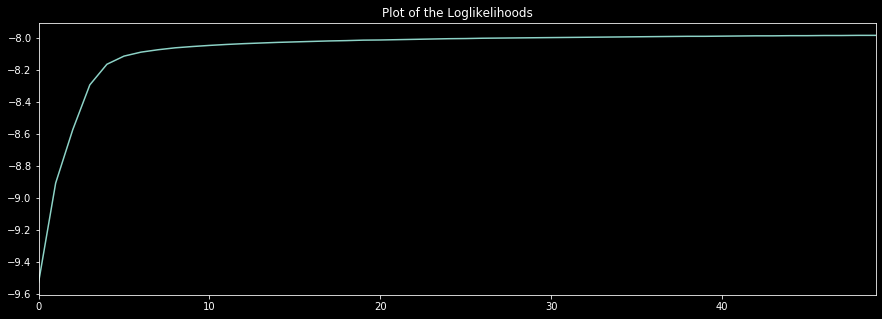

In [24]:
import pandas as pd

# plot the loglikehihoods
# plot the elbow    
fig = plt.figure(figsize=(15, 5))
pd.Series(loglikes).plot(title='Plot of the Loglikelihoods')


In [25]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_v2, corpus,id2word)
vis

/home/quartermaine/anaconda3/envs/tensorflow/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.075145  0.238183       1        1  17.258539
8     -0.100151  0.031737       2        1  15.973639
3     -0.113978 -0.003310       3        1  13.405092
2     -0.092099 -0.091058       4        1  12.787088
0     -0.159411 -0.164737       5        1  12.618202
6     -0.022313  0.146794       6        1  11.557371
5      0.027155 -0.092068       7        1   6.293804
9      0.134388 -0.062968       8        1   4.078117
4      0.166930 -0.013209       9        1   3.574061
7      0.234625  0.010634      10        1   2.454077, topic_info=     Category        Freq       Term       Total  loglift  logprob
140   Default  570.000000    america  570.000000  30.0000  30.0000
25    Default  466.000000      world  466.000000  29.0000  29.0000
1362  Default  176.000000       care  176.000000  28.0000  28.0000
189   Default  195.000000        tax  195.000000  27.0000  27.0000
1046  Default  291.000000   children  291.000000  26.0000  26.0000
...       ...         ...        ...         ...      ...      ...
2135  Topic10    7.188360    special   47.691616   1.8151  -5.5229
4     Topic10    8.669461  president  149.230988   0.8617  -5.3356
139   Topic10    6.182659    address   34.013214   2.0024  -5.6736
1003  Topic10    5.728278      women   73.779327   1.1518  -5.7500
819   Topic10    5.671569       away   34.718407   1.8956  -5.7599

[675 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
45        1  0.206733      able
45        3  0.222636      able
45        4  0.540687      able
45        8  0.031805      able
5029      5  0.979121  accounts
...     ...       ...       ...
28        3  0.108993     young
28        4  0.638387     young
28        7  0.202416     young
7897     10  0.911029    zarfos
5329      3  0.944359     zones

[1388 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 4, 3, 1, 7, 6, 10, 5, 8])

How do you interpret your plot? What would be a reasonable choice for the number of passes? Retrain your LDA model with that number and re-inspect the topics it finds. Do you consider the new topics to be &lsquo;better&rsquo; than the ones that you got from the 1-pass model in Problem&nbsp;5?

*TODO: Insert your discussion of these questions here*

<div class="alert alert-info">
    Please read the section ‘General information’ on the ‘Labs’ page of the course website before submitting this notebook!
</div>